# S&P500 Forecasting

- **Autores:** Guilherme Magalhães, João Baptista, Francisco Martins, Nuno Moreira
- **Universidade:** Faculdade de Ciências da Universidade do Porto
- **Cadeira:** Laboratório de Inteligência Artificial e Ciência de Dados (CC3044)

## Problema

No contexto da cadeira de LABIACD (CC3044), foi-nos pedido para desenvolver um modelo de aprendizagem computacional, capaz de prever os preços futuros das ações (stocks) do índice S&P500, e aplicar métodos de otimização para selecionar o melhor conjunto de stocks para investimento diário.

## Contexto Cronológico

No decorrer deste projeto, simulamos um contexto de trabalho em que, no final de dezembro de 2023, um investidor nos pediu um programa capaz de prever os preços das ações do índice S&P500, para todos os dias de janeiro de 2024.

Assim, elaboramos um modelo que combina previsões baseadas em dados históricos (desde janeiro de 2013 até dezembro de 2023) com técnicas de otimização, para maximizar o retorno, criando uma solução para os desafios financeiros do mundo real.

## Introdução
Neste notebook vamos:
- Realizar *feature engineering*.
- Implementar um *RandomForestRegressor* para cada setor, assim como a avaliação das suas performances.

De seguida, iremos utilizar as previsões dos modelos para janeiro de 2024, no notebook *portfolio.ipynb*.

### Imports Necessários

In [57]:
import pandas as pd
import numpy as np
import os
import pickle
import shap
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.model_selection import ParameterGrid

### Funções para:
- Analisar a performance do modelo.
- Guardar e carregar dados.

In [58]:
def performance_metrics(y_pred,y_test):
    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_test, y_pred)

    # MAPE (Mean Absolute Percentage Error)
    n = len(y_pred)
    mape = 0
    error = 0 # quando o stock nao teve alteracao e o crescimento foi de 0% descartamos
    for i in range(n):
        if y_test.iloc[i] == 0: # evitar dividir por 0
            error += 1
            continue
        mape += (abs(y_test.iloc[i]-y_pred[i]) / (y_test.iloc[i]))
    mape *= 100/n 

    print(f"Root Mean Squared Error (RMSE): {rmse:.5f}")
    print(f"Mean Absolute Error (MAE): {mae:.5f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.5}% - (casos onde y_test=0: {error})")
    return[rmse,mae,mape]


def save_pkl(data, path):
    try:
        with open(path, "wb") as saved_data:
            pickle.dump(data, saved_data)
    except:
        print('Fail to save data')

def load_pkl(path):
    try:
        with open(path, "rb") as loaded_data:
            to_return = pickle.load(loaded_data)
        return to_return
    except:
        print('Fail to load data')
        return None

#### *Feature Engineering*
De forma a termos uma melhor perspetiva das flutuações dos preços dos stocks ao longo do tempo, implementamos as seguintes *features*:

- **day_of_week** : dia da semana (0 = segunda, 1 = terça-feira, 2 = quarta-feira, 3 = quinta-feira, 4 = sexta-feira)
- **daily_return_1** : crescimento diário do dia anterior
- **daily_return_2** : crescimento diário de há dois dias atrás
- **daily_return_3** : crescimento diário de há três dias atrás
- **weekly_return** : soma do crescimento diário dos 5 dias anteriores
- **volatility_prev_day** : volatilidade entre o preço mais alto e mais baixo do dia anterior
- **deviation** : desvio padrão calculado a partir do crescimento dos 20 dias anteriores

Assim, conseguimos obter um maior conhecimento sobre as dinâmicas dos preços.

In [59]:
def data_engineering(dataset) -> pd.DataFrame:
    final_df = pd.DataFrame()
    # garantir que index esta como data
    dataset.index = pd.to_datetime(dataset.index)

    for company in dataset["ticker"].unique():
        sub_set = dataset[dataset["ticker"] == company].copy()

        sub_set['day_of_week'] = sub_set.index.dayofweek  # 0=segunda, 1=terca, ... , 4=sexta
        # crescimento do ultimos 3 dias
        sub_set['daily_return_1'] = round((sub_set["close"]-sub_set["open"])/ sub_set["open"],6).shift(1)
        sub_set['daily_return_2'] = round((sub_set["close"]-sub_set["open"])/ sub_set["open"],6).shift(2)
        sub_set['daily_return_3'] = round((sub_set["close"]-sub_set["open"])/ sub_set["open"],6).shift(3)
        # crescimento da ultima semana
        sub_set['close_prev_day'] = sub_set['close'].shift(1)
        sub_set['close_last_week'] = sub_set['close'].shift(5) # cada semana tem 5 dias de trading
        sub_set['weekly_return'] = round((sub_set["close_prev_day"]-sub_set["close_last_week"])/ sub_set["close_last_week"],6)
        # volatilidade do dia anterior
        sub_set['volatility_prev_day'] = round((sub_set['high'] - sub_set['low']) / sub_set['open'],6).shift(1)

        sub_set['deviation'] = sub_set['daily_return_1'].rolling(window=20).std()

        sub_set['target'] = round((sub_set["close"]-sub_set["open"])/ sub_set["open"],6)

        final_df = pd.concat([final_df,sub_set])

    final_df = final_df.dropna()
    final_df = final_df.drop(['close_prev_day', 'close_last_week'], axis=1)

    return final_df


### Exemplo da Criação de um Modelo
Vamos demonstrar como funciona para criar um modelo para o setor *Industrials*

In [60]:
df_train = pd.read_csv("dataset_by_sector/train/Industrials.csv", index_col=0)
df_test = pd.read_csv("dataset_by_sector/test/Industrials.csv", index_col=0)
df_train = data_engineering(df_train.copy())
df_test = data_engineering(df_test.copy())

In [61]:
df_test

,open,high,low,close,adjclose,volume,ticker,day_of_week,daily_return_1,daily_return_2,daily_return_3,weekly_return,volatility_prev_day,deviation,target
2023-11-01,48.029999,50.020000,47.634998,49.660000,49.066383,5725500,CARR,2,0.006760,0.008731,0.008458,0.013180,0.020490,0.022156,0.033937
2023-11-02,50.740002,50.990002,49.810001,49.970001,49.372681,5897400,CARR,3,0.033937,0.006760,0.008731,0.070259,0.049657,0.023279,-0.015175
2023-11-03,50.919998,52.419998,50.470001,50.529999,49.925980,4212000,CARR,4,-0.015175,0.033937,0.006760,0.074624,0.023256,0.023323,-0.007659
2023-11-06,50.419998,50.630001,49.919998,50.270000,49.669090,3496700,CARR,0,-0.007659,-0.015175,0.033937,0.066709,0.038295,0.020020,-0.002975
2023-11-07,50.119999,50.490002,49.620998,50.450001,49.846939,3605500,CARR,1,-0.002975,-0.007659,-0.015175,0.054763,0.014082,0.019053,0.006584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,111.900002,113.059998,111.709999,112.639999,111.410484,829300,XYL,4,0.008215,-0.015530,0.006222,0.008761,0.013901,0.007059,0.006613
2023-12-26,112.540001,113.779999,112.510002,113.620003,112.379784,440300,XYL,1,0.006613,0.008215,-0.015530,0.017433,0.012064,0.007096,0.009597
2023-12-27,113.910004,114.529999,113.690002,114.379997,113.131493,1007700,XYL,2,0.009597,0.006613,0.008215,0.018283,0.011285,0.007229,0.004126
2023-12-28,114.320000,114.889999,113.919998,114.320000,113.072144,709100,XYL,3,0.004126,0.009597,0.006613,0.042947,0.007374,0.006838,0.000000


### Exemplo de Treino e Teste do Modelo

In [62]:
predictors = ['day_of_week', 'daily_return_1', 'daily_return_2', 'daily_return_3','weekly_return', 'volatility_prev_day','deviation']
# dividir os dados em treino e teste
X_train = df_train[predictors]
y_train = df_train['target']  # target
X_test = df_test[predictors]
y_test = df_test['target']  # target

# treinar a random forest regressor
rf = RandomForestRegressor(n_estimators= 500, min_samples_split = 50, random_state=42)
rf.fit(X_train, y_train)

# prever
y_pred = rf.predict(X_test)

KeyboardInterrupt: 

In [47]:
performance_metrics(y_pred,y_test)

Root Mean Squared Error (RMSE): 0.01267
Mean Absolute Error (MAE): 0.00898
Mean Absolute Percentage Error (MAPE): 27.627% - (casos onde y_test=0: 6)


[0.012671569703042543, 0.008981662807904776, 27.626788977593595]

### Valores Reais VS Valores Previstos

In [49]:
print("Valor de crescimento diário ao longo do mes de novembro e dezembro de 2023\nNo setor 'Industrials' com 30 empresas")
for i in range(len(y_test)):
    print(f"Valor real: {y_test.iloc[i]} | {y_pred[i]:.6f} :Valor previsto ")

Valor de crescimento diário ao longo do mes de novembro e dezembro de 2023
No setor 'Industrials' com 30 empresas
Valor real: 0.033937 | 0.000116 :Valor previsto 
Valor real: -0.015175 | -0.002062 :Valor previsto 
Valor real: -0.007659 | 0.002624 :Valor previsto 
Valor real: -0.002975 | 0.000435 :Valor previsto 
Valor real: 0.006584 | -0.000025 :Valor previsto 
Valor real: 0.007714 | -0.000584 :Valor previsto 
Valor real: -0.016767 | -0.000346 :Valor previsto 
Valor real: 0.0102 | -0.000240 :Valor previsto 
Valor real: -0.003911 | -0.002093 :Valor previsto 
Valor real: 0.011105 | 0.001140 :Valor previsto 
Valor real: -0.007018 | -0.003145 :Valor previsto 
Valor real: 0.010744 | 0.003951 :Valor previsto 
Valor real: 0.00453 | 0.000225 :Valor previsto 
Valor real: 0.006385 | -0.002294 :Valor previsto 
Valor real: -0.007902 | 0.000104 :Valor previsto 
Valor real: -0.000758 | -0.000683 :Valor previsto 
Valor real: 0.007224 | 0.000112 :Valor previsto 
Valor real: -0.009687 | -0.000460 :Valo

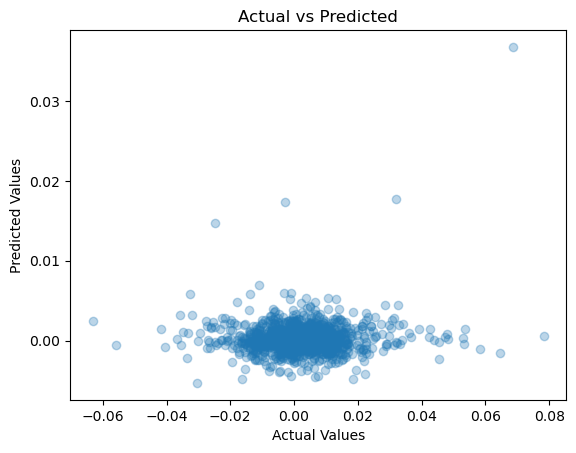

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.show()


**Nota**: Estes valores foram obtidos com um modelo com hiper-parâmetros escolhidos à sorte, logo, não iremos discutir os seus resultados. Mais à frente, realizamos um GridSearch para a escolha dos melhores hiper-parâmetros, onde discutimos os resultados.

### *Tuning* dos Hiper-Parâmetros
Para a escolha dos hiper-parâmetros, realizamos um *GridSearch* específico para cada setor segundo a seguinte ordem: 

- 0 - 'Consumer_Discretionary'

- 1 - 'Energy'

- 2 - 'Health_Care'

- 3 - 'Industrials'
  
- 4 - 'Information_Technology'

In [17]:
if not os.path.exists("models_test/"):
    os.mkdir("models_test/")


path_train = "dataset_by_sector/train/"
train_df = os.listdir(path_train)

path_test = "dataset_by_sector/test/"
test_df = os.listdir(path_test)

metrics = {}

# hiper-parametros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 30, 50],
    'min_samples_split': [5, 10, 20, 40],
    'min_samples_leaf': [10, 25, 40],
}


def evaluate_model(params,df_train,df_test):
    predictores = ["day_of_week", "daily_return_1", "daily_return_2", "daily_return_3", "weekly_return", "volatility_prev_day","deviation"]
    
    # features and target
    X_train = df_train[predictores]
    y_train = df_train['target']
    
    X_test = df_test[predictores]
    y_test = df_test['target']
    
    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    perf = performance_metrics(y_pred, y_test)  # metrica costumizada
    return params, {"rmse": perf[0], "mae": perf[1], "mape":perf[2]}


for i in range(len(test_df)):
    print(f"Setor: {train_df[i].split('.')[0]}")
    
    data_train = data_engineering(pd.read_csv(path_train+train_df[i],index_col=0))
    data_test = data_engineering(pd.read_csv(path_test+test_df[i],index_col=0))
    
    # correr a grid search em paralelo, mais rapido
    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(evaluate_model)(params,data_train,data_test) for params in ParameterGrid(param_grid)
    )    
    print()
    
    save_pkl(results,f"models_test/metrics_{train_df[i].split('.')[0]}.pkl")

Setor: Consumer_Discretionary


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 40.4min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 48.2min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 59.1min
[Parallel(n_jobs=-1)]: Done 136 out of 144 | elapsed: 67.9min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 73.2min finished



Setor: Energy


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 31.6min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 38.5min
[Parallel(n_jobs=-1)]: Done 136 out of 144 | elapsed: 44.1min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 47.8min finished



Setor: Health_Care


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 35.0min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 41.7min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 51.4min
[Parallel(n_jobs=-1)]: Done 136 out of 144 | elapsed: 58.1min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 63.0min finished



Setor: Industrials


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 28.3min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 35.8min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 42.0min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 51.8min
[Parallel(n_jobs=-1)]: Done 136 out of 144 | elapsed: 59.6min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 64.2min finished



Setor: Information_Technology


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 34.7min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 40.9min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 49.5min
[Parallel(n_jobs=-1)]: Done 136 out of 144 | elapsed: 57.0min remaining:  3.4min


[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 61.8min finished


### Os Melhores Hiper-Parâmetros
Depois da GridSearch, analisamos os valores dos melhores hiper-parâmetros.

In [19]:
# visualizar os melhores hiper parametros para cada setor
for metrics_path in os.listdir("models_teste2/"):
    results = load_pkl(f"models_teste2/{metrics_path}")
    # os melhores parametros com base no MAPE
    best_params = None
    best_MAPE = float("inf")  # mais proximo de 0 melhor
    metricas = None


    for params, met in results:
        if abs(met["mape"]) < abs(best_MAPE):
            best_MAPE = met["mape"]
            metricas = met
            best_params = params
    print(f"\n{metrics_path[8:-4]}")
    print("Best Parameters:", best_params)
    print("Metricas:", metricas)


Consumer_Discretionary
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 40, 'n_estimators': 100}
Metricas: {'rmse': np.float64(0.013719808137761145), 'mae': 0.009769323141713089, 'mape': np.float64(12.678276289714598)}

Energy
Best Parameters: {'max_depth': 50, 'min_samples_leaf': 25, 'min_samples_split': 5, 'n_estimators': 100}
Metricas: {'rmse': np.float64(0.013657716266990324), 'mae': 0.010109892046573678, 'mape': np.float64(0.04490680235469049)}

Health_Care
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 40, 'min_samples_split': 5, 'n_estimators': 200}
Metricas: {'rmse': np.float64(0.015907543868629897), 'mae': 0.011049038449290819, 'mape': np.float64(1.8180683265219828)}

Industrials
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 200}
Metricas: {'rmse': np.float64(0.01261414180671116), 'mae': 0.008902313654960121, 'mape': np.float64(9.228519199190284)}

Information_Technology
Best Parameter

<hr>

### Guardar Dados e Criar Modelos

- Vamos guardar os datasets finais com os dados gerados.

- Com os hiper-parâmetros obtidos vamos agora criar os respetivos modelos para cada setor.

In [51]:
if not os.path.exists("models/"):
    os.mkdir("models/")

if not os.path.exists("data/"):
    os.mkdir("data/")
if not os.path.exists("data/train"):
    os.mkdir("data/train")
if not os.path.exists("data/test"):
    os.mkdir("data/test")
if not os.path.exists("data/simulation/"):
    os.mkdir("data/simulation/")

params =[{'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 40, 'n_estimators': 100}, # Consumer_Discretionary
         {'max_depth': 50, 'min_samples_leaf': 25, 'min_samples_split': 5, 'n_estimators': 100}, # Energy
         {'max_depth': 10, 'min_samples_leaf': 40, 'min_samples_split': 5, 'n_estimators': 200}, # Health_Care
         {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 200}, # Industrials
         {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 40, 'n_estimators': 100}] # Information_Technology

predictores = ["day_of_week", "daily_return_1", "daily_return_2", "daily_return_3", "weekly_return", "volatility_prev_day","deviation"]

path_train = "dataset_by_sector/train/"
train_df = os.listdir(path_train)

path_test = "dataset_by_sector/test/"
test_df = os.listdir(path_test)

path_simu = "dataset_by_sector/simulate/"
simu_df = os.listdir(path_simu)


#### Guadar dados

In [52]:
for i in range(len(test_df)):
    data_train = data_engineering(pd.read_csv(path_train+train_df[i],index_col=0))
    data_test = data_engineering(pd.read_csv(path_test+test_df[i],index_col=0))
    data_simu = data_engineering(pd.read_csv(path_simu+simu_df[i],index_col=0))
    
    data_train.to_csv(f"data/train/{train_df[i]}")
    data_test.to_csv(f"data/test/{test_df[i]}")
    data_simu.to_csv(f"data/simulation/{simu_df[i]}")

#### Gerar Modelos

Função para analisar as features mais importantes para a previsão.

In [54]:
def feature_importance(predictors, model):
    importance_df = pd.DataFrame({
        'Feature': predictors,
        'Importance': model.feature_importances_
    })
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.title('Importância dos Features', fontsize=14)
    plt.xlabel('Importância', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.gca().invert_yaxis() 
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


Setor: Consumer_Discretionary
Root Mean Squared Error (RMSE): 0.01372
Mean Absolute Error (MAE): 0.00977
Mean Absolute Percentage Error (MAPE): 9.7584% - (casos onde y_test=0: 1)


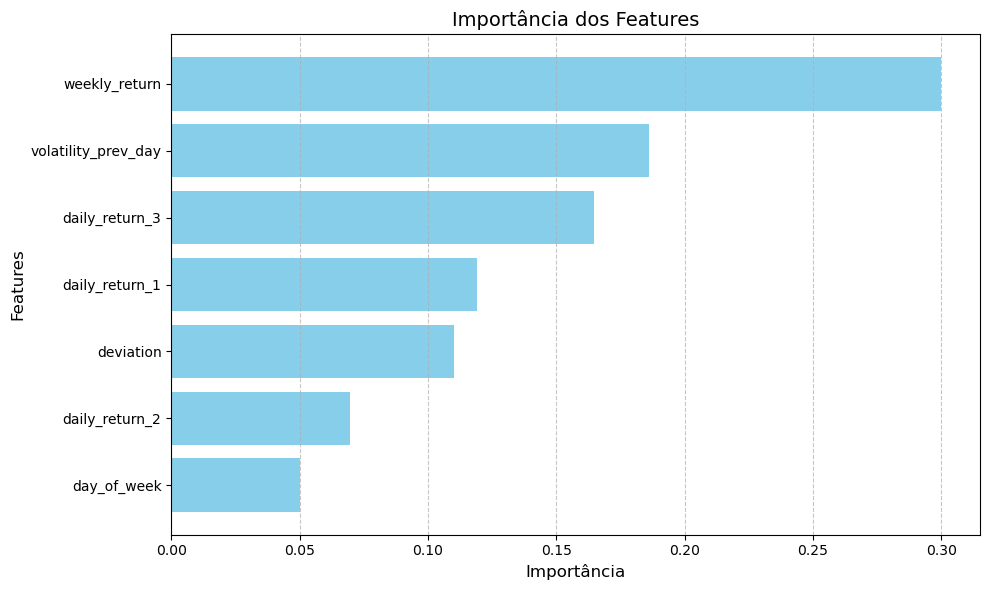


Setor: Energy
Root Mean Squared Error (RMSE): 0.01365
Mean Absolute Error (MAE): 0.01011
Mean Absolute Percentage Error (MAPE): 0.41118% - (casos onde y_test=0: 2)


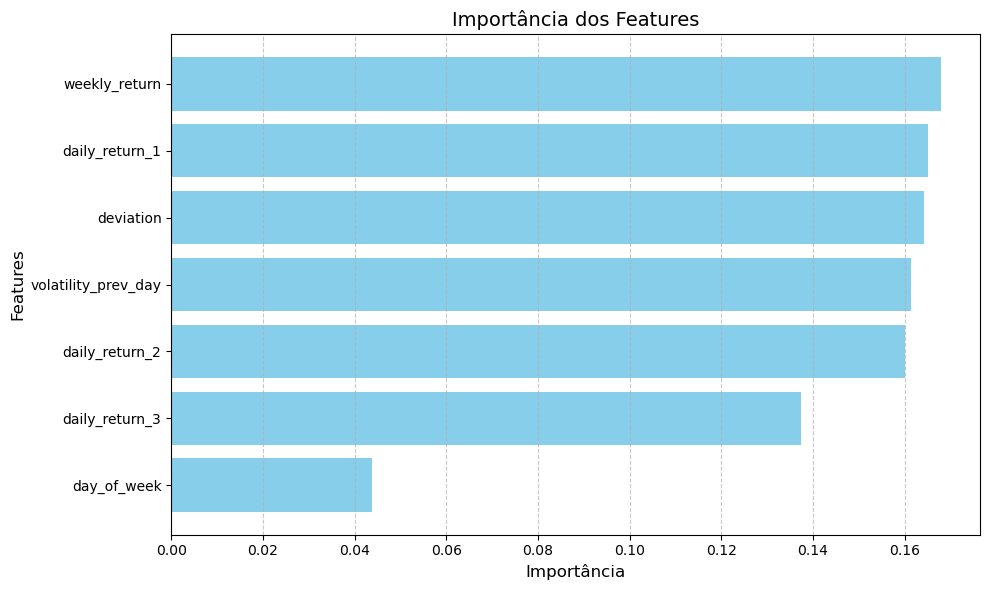


Setor: Health_Care
Root Mean Squared Error (RMSE): 0.01592
Mean Absolute Error (MAE): 0.01109
Mean Absolute Percentage Error (MAPE): 1.1775% - (casos onde y_test=0: 2)


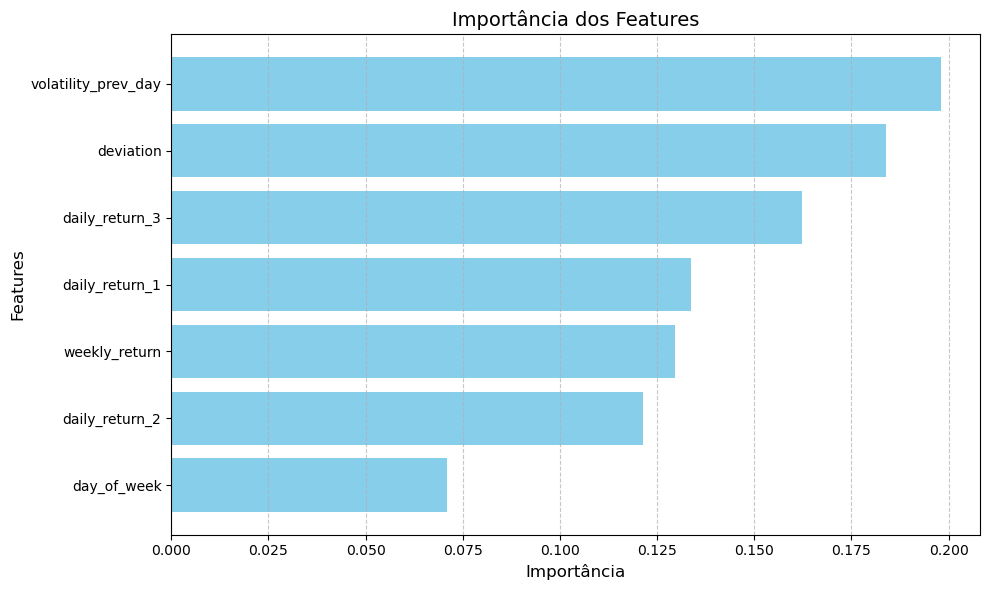


Setor: Industrials
Root Mean Squared Error (RMSE): 0.01259
Mean Absolute Error (MAE): 0.00889
Mean Absolute Percentage Error (MAPE): 9.5267% - (casos onde y_test=0: 6)


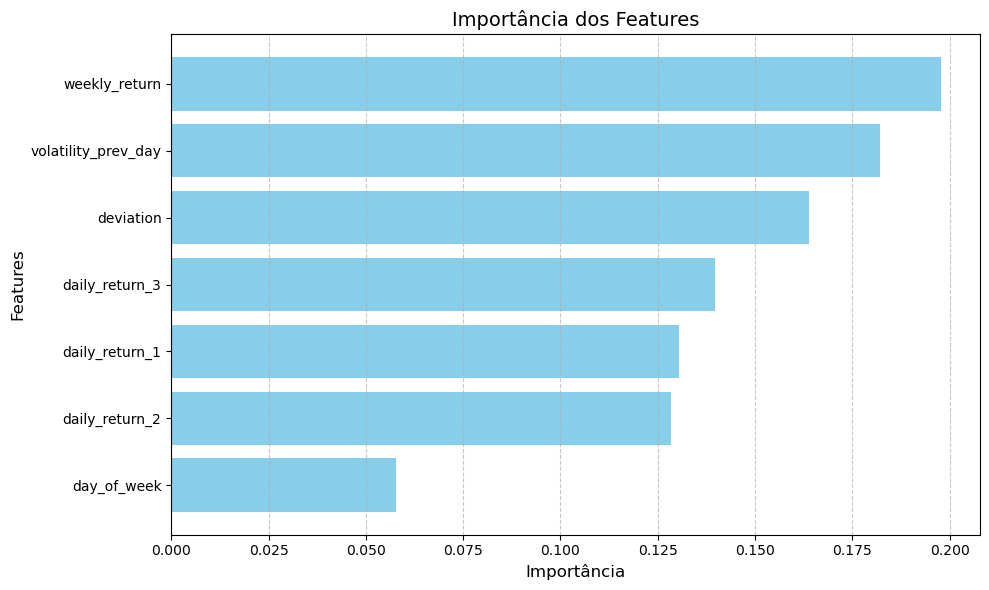


Setor: Information_Technology
Root Mean Squared Error (RMSE): 0.01928
Mean Absolute Error (MAE): 0.01311
Mean Absolute Percentage Error (MAPE): 16.637% - (casos onde y_test=0: 2)


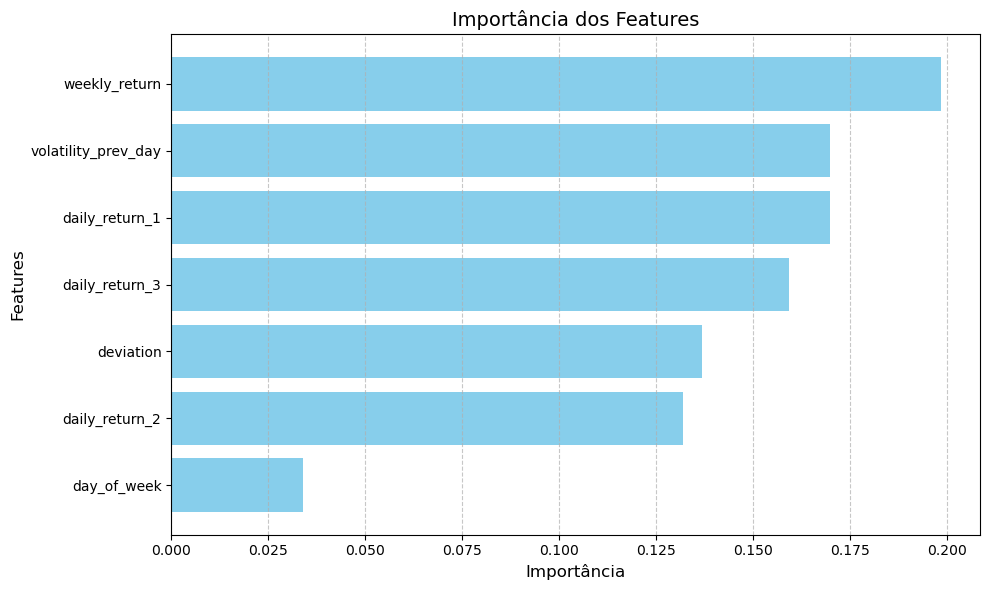

In [56]:
metrics = {}

for i in range(len(test_df)):
    sector = train_df[i].split(".")[0]
    print(f"\nSetor: {sector}")
   
    data_train = data_engineering(pd.read_csv(path_train+train_df[i],index_col=0))
    data_test = data_engineering(pd.read_csv(path_test+test_df[i],index_col=0))

    # features and target
    X_train = data_train[predictores]
    y_train = data_train['target']
    
    X_test = data_test[predictores]
    y_test = data_test['target']
    
    model = RandomForestRegressor(**params[i], random_state=42)
    model.fit(X_train,y_train)
    
    y_pred = model.predict(X_test)
    perf = performance_metrics(y_pred, y_test)
    metrics[sector] = {"rmse": perf[0], "mae": perf[1], "mape":perf[2]} 
    feature_importance(predictores, model)
    save_pkl(model,f"models_deviation/rf_{sector}.pkl")

save_pkl(metrics,f"models_deviation/metrics.pkl")


### Resultados

No que toca ao MAE e RMSE, todos os modelos apresentam bons valores, indicando assim uma boa previsão do valor real da variável objetivo.

Devido à sua sensibilidade com números muito próximos de zero, o valor do MAPE varia bastante de setor para setor (entre 0.41% e 16.64%). Ainda assim, no contexto do problema, os modelos que conseguiram prever números mais próximos dos valores reais foram os dos setores *Health Care* e *Energy*. 

Com estes dados, conseguimos perceber que, de setor para setor, as *features* que acrescentam mais informação ao modelo, tendo assim mais impacto na sua previsão, são diferentes. No entanto, concluímos que, na generalidade dos modelos, as features mais importantes foram a *weekly_return* e a *volatility_prev_day*, sendo claro que a menos importante foi o *day_of_week*.

Para a próxima fase, correspondente à elaboração e otimização do portfolio para investimentos diários (*portfolio.ipynb*), podemos avançar com confiança na performance do modelo, de acordo com os resultados discutidos anteriormente.